In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import category_encoders as ce

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import pickle

from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, plot_confusion_matrix, plot_roc_curve, roc_curve

In [3]:
state = 1992

In [4]:
bank = pd.read_csv('bank_clean_out.csv')

In [5]:
bank 

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,0
4,35,management,married,tertiary,no,231,yes,no,unknown,5,may,1,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44918,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,3,-1,0,1
44919,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,2,-1,0,1
44920,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,5,184,3,1
44921,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,4,-1,0,0


PLAN

Impute
- education dan contact dengan mode (secondary dan cellular)

Encoder:
- education -> ordinal
- job, marital, default, housing, loan, contact -> onehot
- month -> binary

Scaling and PCA:
- Numerical columns

Oversampling -> SMOTE

Model
- Logistic Regression
- Random Forest
- Decision Tree Classifier

Metrics -> pake f1

In [6]:
bank1 = bank.drop(['y'], axis=1)

In [7]:
X = bank1
y = bank['y']

In [8]:
#data splitting

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = state)

In [9]:
logit = LogisticRegression(class_weight='balanced', random_state=state)
rfc = RandomForestClassifier(max_depth=10, class_weight='balanced', random_state=state)
dtc = DecisionTreeClassifier(max_depth = 5, class_weight='balanced', random_state = state)
smote = SMOTE(random_state = state)

In [10]:
ordinal_mapping = [
    {'col': 'education',
    'mapping': {None:0, 'primary': 1, 'secondary': 2, 'tertiary': 3}}
]

numerical_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('PCA', PCA())
])

onehot_pipeline = Pipeline([
    ('impute_cat', SimpleImputer(strategy='most_frequent', missing_values = 'unknown')),
    ('onehot', OneHotEncoder(drop='first'))
])
binary_pipeline = Pipeline([
    ('binary', ce.BinaryEncoder())
])

ordinal_pipeline = Pipeline([
    ('impute_cat', SimpleImputer(strategy='most_frequent', missing_values = 'unknown')),
    ('ordinal', OrdinalEncoder())
])

transformer = ColumnTransformer([
    ('num_pipe', numerical_pipeline, 'age balance day campaign pdays previous'.split()),
    ('onehot_pipe', onehot_pipeline, ['job', 'marital', 'default', 'housing', 'loan', 'contact']),
    ('binary_pipe', binary_pipeline, ['month']),
    ('ordinal_pipe', ordinal_pipeline, ['education'])
], remainder='passthrough')

In [11]:
#DTC Pipe
dtc_pipeline = Pipeline([
    ('transformer', transformer),
    ('rfe', RFE(dtc)),
    ('resampling', smote),
    ('clf', dtc)
])

In [12]:
#Logit Pipe
logit_pipeline = Pipeline([
    ('transformer', transformer),
    ('rfe', RFE(logit)),
    ('resampling', smote),
    ('clf', logit)
])

In [13]:
#RFC Pipe
rfc_pipeline = Pipeline([
    ('transformer', transformer),
    ('rfe', RFE(rfc)),
    ('resampling', smote),
    ('clf', rfc)
])

In [14]:
rs = RepeatedStratifiedKFold(n_splits=5, random_state=state)

dtc_score = cross_val_score(dtc_pipeline, X_train_val, y_train_val, scoring='f1', cv=rs, n_jobs=-1, verbose=1)
logit_score = cross_val_score(logit_pipeline, X_train_val, y_train_val, scoring='f1', cv=rs, n_jobs=-1, verbose=1)
rfc_score = cross_val_score(rfc_pipeline, X_train_val, y_train_val, scoring='f1', cv=rs, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 12.1min finished


In [59]:
print('DTC Val Score:', dtc_score, '\nDTC Val Score: Mean', dtc_score.mean())

DTC Val Score: [0.33286319 0.30136986 0.35306667 0.41445783 0.39277389 0.33265306
 0.30066146 0.32712215 0.3357216  0.35668277 0.29292009 0.30676812
 0.37820914 0.35216916 0.36111111 0.36954207 0.34375    0.38712972
 0.34068136 0.35294118 0.3161157  0.349642   0.34154689 0.36314363
 0.3446729  0.33616808 0.33209418 0.32709938 0.37017167 0.35820896
 0.33080534 0.38986119 0.33806452 0.38076416 0.36220472 0.2980713
 0.38876147 0.37440191 0.38327526 0.32983275 0.34928425 0.31086303
 0.38290187 0.32496307 0.32671864 0.39354839 0.35054175 0.32517321
 0.35364042 0.36439114] 
DTC Val Score: Mean 0.3485905243713814


In [37]:
print('Logit Val Score:', logit_score, '\nLogit Val Score: Mean', logit_score.mean())

Logit Val Score: [0.31315936 0.30733138 0.31296655 0.31344148 0.33674699 0.30824373
 0.31670404 0.31047563 0.3216459  0.32642487 0.32291368 0.31461335
 0.31949614 0.32076566 0.30463576 0.31517184 0.31319911 0.30625
 0.30890973 0.31543245 0.30037048 0.31352941 0.31914894 0.31179138
 0.32250712 0.3090699  0.31378132 0.32287507 0.32583258 0.3121923
 0.32388664 0.30076901 0.31959056 0.31452306 0.3032368  0.31112416
 0.31593407 0.31306818 0.31007752 0.31967451 0.3197756  0.31830239
 0.31842475 0.3112344  0.31696813 0.32004622 0.3050557  0.30877193
 0.32082498 0.32231884] 
Logit Val Score: Mean 0.31506467124509097


In [65]:
print('RFC Val Score:', rfc_score, '\nRFC Val Score: Mean', rfc_score.mean())

RFC Val Score: [0.39540027 0.3897237  0.41382532 0.42503639 0.42626368 0.40627973
 0.42179427 0.39710843 0.42303873 0.43964671 0.42597147 0.40059055
 0.41814596 0.42195368 0.41814059 0.39980961 0.40894271 0.41612091
 0.41440553 0.41650854 0.39290848 0.39706601 0.42701723 0.40966184
 0.43975904 0.39068441 0.40267176 0.43146274 0.43469282 0.39942391
 0.42977667 0.38924339 0.40240518 0.41806824 0.39514246 0.38482143
 0.39011925 0.40038873 0.40462963 0.41389728 0.42110221 0.40413997
 0.42223306 0.41941748 0.39866794 0.42542787 0.38589981 0.40655738
 0.43167552 0.42489062] 
RFC Val Score: Mean 0.41145118227799415


In [17]:
dtc_pipeline.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('num_pipe',
                                    Pipeline(steps=[('scale', StandardScaler()),
                                                    ('PCA', PCA())]),
                                    ['age', 'balance', 'day', 'campaign', 'pdays',
                                     'previous']),
                                   ('onehot_pipe',
                                    Pipeline(steps=[('impute_cat',
                                                     SimpleImputer(missing_values='unknown',
                                                                   strategy='most_frequent')),
                                                    ('onehot',
                                                     OneHotEncoder(drop='first'))]),
                                    ['job', 'marital', 'default', 'housing',
                                     'loan', '

In [15]:
dtc_params = {
    'clf__max_depth': [5,7,10],
    'clf__min_samples_split': [2,6,10],
    'clf__min_samples_leaf': [1,2,5],
    'clf__criterion': ['entropy', 'gini'],
    'rfe__n_features_to_select': [None,5,10]
    
}

skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=state)

dtc_grid = GridSearchCV(dtc_pipeline, param_grid=dtc_params, scoring ='f1', n_jobs =-1, cv = skf, verbose=1)
dtc_grid.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


C:\Users\user\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1992, shuffle=True),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipe',
                                                                         Pipeline(steps=[('scale',
                                                                                          StandardScaler()),
                                                                                         ('PCA',
                                                                                          PCA())]),
                                                                         ['age',
                                                                          'balance',
                                                                          'day',
                                               

In [19]:
logit_pipeline.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('num_pipe',
                                    Pipeline(steps=[('scale', StandardScaler()),
                                                    ('PCA', PCA())]),
                                    ['age', 'balance', 'day', 'campaign', 'pdays',
                                     'previous']),
                                   ('onehot_pipe',
                                    Pipeline(steps=[('impute_cat',
                                                     SimpleImputer(missing_values='unknown',
                                                                   strategy='most_frequent')),
                                                    ('onehot',
                                                     OneHotEncoder(drop='first'))]),
                                    ['job', 'marital', 'default', 'housing',
                                     'loan', '

In [16]:
logit_params = {
    'clf__C': np.linspace(0,1,5),
    'clf__solver': ['lbfgs', 'liblinear', 'newton-cg']

}

skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=state)

logit_grid = GridSearchCV(logit_pipeline, param_grid=logit_params, scoring='f1', cv=skf, verbose=1, n_jobs=-1)
logit_grid.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.31798606 0.31793319 0.31798606
 0.31787137 0.31781834 0.31783597 0.31781617 0.31785421 0.31783628
 0.31787263 0.31783597 0.31783628]
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1992, shuffle=True),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipe',
                                                                         Pipeline(steps=[('scale',
                                                                                          StandardScaler()),
                                                                                         ('PCA',
                                                                                          PCA())]),
                                                                         ['age',
                                                                          'balance',
                                                                          'day',
                                               

In [44]:
rfc_pipeline.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('num_pipe',
                                    Pipeline(steps=[('scale', StandardScaler()),
                                                    ('PCA', PCA())]),
                                    ['age', 'balance', 'day', 'campaign', 'pdays',
                                     'previous']),
                                   ('onehot_pipe',
                                    Pipeline(steps=[('impute_cat',
                                                     SimpleImputer(missing_values='unknown',
                                                                   strategy='most_frequent')),
                                                    ('onehot',
                                                     OneHotEncoder(drop='first'))]),
                                    ['job', 'marital', 'default', 'housing',
                                     'loan', '

In [61]:
rfc_params = {
    'clf__max_depth': [None, 10, 20],
    'clf__n_estimators': [50, 100, 200],
    'clf__max_features': ['auto', 'sqrt'],
    'clf__criterion': ['entropy', 'gini'],
    'rfe__n_features_to_select': [None,5,10]
      
}

rfc_grid = RandomizedSearchCV(rfc_pipeline, rfc_params, n_iter=150, scoring='f1', cv=skf, verbose=1, n_jobs=-1)
rfc_grid.fit(X_train_val, y_train_val)

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 108 is smaller than n_iter=150. Running 108 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 

In [17]:
dtc_grid.best_params_

{'clf__criterion': 'entropy',
 'clf__max_depth': 7,
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 2,
 'rfe__n_features_to_select': 10}

In [18]:
logit_grid.best_params_

{'clf__C': 0.25, 'clf__solver': 'lbfgs'}

In [47]:
rfc_grid.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
rfc_tuned = rfc_grid.best_estimator_
# logit_tuned = logit_grid.best_estimator_
# dtc_tuned = dtc_grid.best_estimator_

In [20]:
# rfc_tuned = rfc_grid.best_estimator_
logit_tuned = logit_grid.best_estimator_
dtc_tuned = dtc_grid.best_estimator_

In [23]:
dtc_tuned_score = cross_val_score(dtc_tuned, X_train_val, y_train_val, scoring='f1', cv=skf, n_jobs=-1, verbose=1)
logit_tuned_score = cross_val_score(logit_tuned, X_train_val, y_train_val, scoring='f1', cv=skf, n_jobs=-1, verbose=1)
# rfc_tuned_score = cross_val_score(rfc_tuned, X_train_val, y_train_val, scoring='f1', cv=rs, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.8s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.3s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s finished


In [24]:
print('DTC Tuned Score:', dtc_tuned_score, '\nDTC Tuned Score: Mean', dtc_tuned_score.mean())

DTC Tuned Score: [0.33207288 0.33865506 0.38469493 0.42525253 0.37051953] 
DTC Tuned Score: Mean 0.370238984754225


In [25]:
print('Logit Tuned Score:', logit_tuned_score, '\nLogit Tuned Score: Mean', logit_tuned_score.mean())

Logit Tuned Score: [0.31951016 0.30654762 0.3131397  0.31421159 0.33652122] 
Logit Tuned Score: Mean 0.31798605622442655


In [ ]:
print('RFC Tuned Score:', rfc_tuned_score, '\nRFC Tuned Score: Mean', rfc_tuned_score.mean())

In [26]:
cv_res_df = pd.DataFrame(rfc_pipeline.cv_results_)
cv_res_df.head()

AttributeError: 'Pipeline' object has no attribute 'cv_results_'

In [ ]:
cv_res_df[cv_res_df['rank_test_score'] == 1]

In [27]:
model_default = rfc_pipeline.fit(X_train_val, y_train_val)
y_pred_default = model_default.predict(X_test)

print(classification_report(y_test, y_pred_default))

C:\Users\user\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


              precision    recall  f1-score   support

           0       0.93      0.87      0.90      7934
           1       0.34      0.51      0.41      1051

    accuracy                           0.83      8985
   macro avg       0.64      0.69      0.65      8985
weighted avg       0.86      0.83      0.84      8985



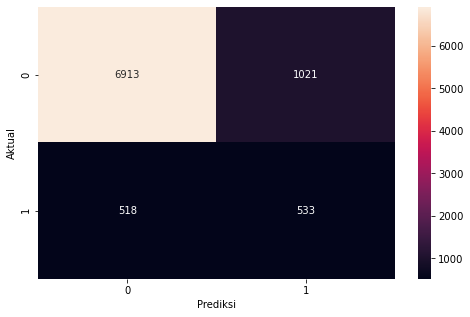

In [28]:
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred_default), annot=True, fmt='.0f', ax=ax)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

In [ ]:
#model 2: jadi lebih bagus
model_tuned = rfc_tuned.fit(X_train_val, y_train_val)
y_pred_tuned = model_tuned.predict(X_test)

print(classification_report(y_test, y_pred_tuned))

In [ ]:
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred_tuned), annot=True, fmt='.0f', ax=ax)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

In [29]:
# model = model_tuned
model = model_default

In [30]:
model.fit(X,y)

C:\Users\user\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler()),
                                                                  ('PCA',
                                                                   PCA())]),
                                                  ['age', 'balance', 'day',
                                                   'campaign', 'pdays',
                                                   'previous']),
                                                 ('onehot_pipe',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(missing_values='unknown',
                                                                   

In [31]:
filename = 'model.sav'
pickle.dump(model, open(filename, 'wb'))

In [32]:
openfile = 'model.sav'
loaded_model = pickle.load((open(openfile, 'rb')))
loaded_model

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler()),
                                                                  ('PCA',
                                                                   PCA())]),
                                                  ['age', 'balance', 'day',
                                                   'campaign', 'pdays',
                                                   'previous']),
                                                 ('onehot_pipe',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(missing_values='unknown',
                                                                   

Coba predik 1 df

In [33]:
test = pd.read_csv('test.csv', sep=';')

In [34]:
test

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


In [35]:
test.drop(columns = ['poutcome', 'duration'], inplace=True)

In [36]:
testx = test.drop(columns = 'y')
testy = test.y

In [37]:
testy.replace(['yes', 'no'], [1,0], inplace=True)

In [38]:
testy

0       0
1       0
2       0
3       0
4       0
       ..
4516    0
4517    0
4518    0
4519    0
4520    0
Name: y, Length: 4521, dtype: int64

In [39]:
y_pred_test = loaded_model.predict(testx)

In [40]:
results = pd.DataFrame({'id': testx.index, 'label' : y_pred_test})
results

,id,label
0,0,1
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
4516,4516,0
4517,4517,0
4518,4518,0
4519,4519,0


In [41]:
results['asli'] = testy
results[results['label'] != results['asli']]

,id,label,asli
0,0,1,0
5,5,1,0
17,17,1,0
19,19,1,0
27,27,1,0
...,...,...,...
4494,4494,0,1
4503,4503,0,1
4504,4504,0,1
4505,4505,0,1


In [42]:
747/4521

0.16522893165228933